#Import các thư viện cần thiết

In [63]:
import gensim
from gensim.models import KeyedVectors, Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import random
from collections import Counter
import pandas as pd
import os
import requests
import zipfile
import io
import re

# Tải các resource cần thiết từ nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NguyenKhang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NguyenKhang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Tiền xử lý dữ liệu

In [93]:
# Chỉ định nghĩa một số từ dừng tiếng Việt phổ biến
vietnamese_stopwords = [
    'và', 'là', 'của', 'có', 'được', 'trong', 'để', 'những', 'này', 'các',
    'với', 'đã', 'cho', 'không', 'một', 'về', 'như', 'những', 'khi', 'đến',
    'từ', 'theo', 'tại', 'thì', 'mà', 'vì', 'nên', 'bị', 'rất', 'nhiều',
    'cũng', 'phải', 'sau', 'sẽ', 'còn', 'bởi', 'tất', 'mỗi', 'ai', 'đây',
    'vậy', 'lúc', 'này', 'thế', 'nhưng', 'để', 'vì'
]

def preprocess_text(text, remove_stopwords=False):
    """
    Tiền xử lý văn bản nâng cao: chuyển thành chữ thường, tách từ, 
    loại bỏ dấu câu, số, và stopwords (tùy chọn)
    """
    # Chuyển thành chữ thường
    text = text.lower()
    
    # Loại bỏ dấu câu và số
    text = re.sub(r'[^\w\s]|[\d]', ' ', text)
    
    # Tách từ
    tokens = word_tokenize(text)
    
    # Loại bỏ từ dừng nếu được yêu cầu
    if remove_stopwords:
        tokens = [token for token in tokens if token not in vietnamese_stopwords]
    
    # Loại bỏ khoảng trắng thừa
    tokens = [token for token in tokens if token.strip()]
    
    return tokens

# Đọc dữ liệu trực tiếp từ file CSV
df = pd.read_csv('sample_data.csv')
documents = df['text'].tolist()

# Chuyển đổi nhãn thành số
label_map = {'chó': 0, 'mèo': 1, 'cả hai': 2}
labels = [label_map[label] for label in df['label']]

# Tiền xử lý dữ liệu
tokenized_docs = [preprocess_text(doc, remove_stopwords=True) for doc in documents]

print(f"Số lượng tài liệu: {len(tokenized_docs)}")
print(f"Ví dụ tài liệu đã tiền xử lý (câu thứ nhất): {tokenized_docs[0]}")
print(f"Phân bố nhãn: Chó: {labels.count(0)}, Mèo: {labels.count(1)}, Cả hai: {labels.count(2)}")

Số lượng tài liệu: 21
Ví dụ tài liệu đã tiền xử lý (câu thứ nhất): ['chó', 'săn', 'thỏ', 'khả', 'năng', 'đánh', 'hơi', 'cực', 'kỳ', 'nhạy', 'bén', 'thể', 'phân', 'biệt', 'mùi', 'xa']
Phân bố nhãn: Chó: 7, Mèo: 7, Cả hai: 7


In [94]:
# Tải mô hình Word2Vec pretrained cho tiếng Việt
from gensim.models import KeyedVectors


def download_pretrained_model():
    """
    Tải mô hình Word2Vec pretrained cho tiếng Việt từ internet
    """
    # Đường dẫn tới file pretrained model
    model_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.vi.300.vec.gz"
    model_path = "cc.vi.300.vec.gz"
    extracted_path = "cc.vi.300.vec"
    
    print("Đang tải mô hình pretrained từ internet...")
    
    # Kiểm tra nếu mô hình đã tồn tại
    if not os.path.exists(extracted_path):
        # Tải file mô hình
        try:
            import gzip
            import shutil
            
            # Tải file nén
            if not os.path.exists(model_path):
                r = requests.get(model_url, stream=True)
                with open(model_path, 'wb') as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        if chunk:
                            f.write(chunk)
            
            # Giải nén file
            with gzip.open(model_path, 'rb') as f_in:
                with open(extracted_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
                    
            print(f"Đã tải và giải nén mô hình pretrained thành công!")
        
        except Exception as e:
            print(f"Lỗi khi tải mô hình pretrained: {e}")
            return None
    else:
        print("Mô hình đã tồn tại, không cần tải lại.")
    
    return extracted_path

# Hàm tải mô hình pretrained fastText cho tiếng Việt
def load_pretrained_word2vec(limit=100000):
    """
    Tải mô hình Word2Vec pretrained
    limit: Số lượng từ tối đa để tải (để tiết kiệm bộ nhớ)
    """
    try:
        # Tải mô hình từ internet nếu cần
        model_path = download_pretrained_model()
        
        if model_path is None or not os.path.exists(model_path):
            raise FileNotFoundError("Không tìm thấy mô hình pretrained")
        
        # Tải mô hình với số từ vựng giới hạn để tiết kiệm bộ nhớ
        word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=False, limit=limit)
        print(f"Đã tải mô hình pretrained với {len(word2vec_model.key_to_index)} từ vựng")
        return word2vec_model
    
    except Exception as e:
        print(f"Không thể tải mô hình pretrained: {e}")
        print("Sẽ sử dụng mô hình dự phòng thay thế...")
        
        # Nếu không tải được mô hình pretrained, tạo mô hình nhỏ từ dữ liệu có sẵn
        # CHỈ dùng làm giải pháp dự phòng
        from gensim.models import Word2Vec
        fallback_model = Word2Vec(tokenized_docs, vector_size=300, window=5, min_count=1, workers=4).wv
        print(f"Đã tạo mô hình dự phòng với {len(fallback_model.key_to_index)} từ vựng")
        print("LƯU Ý: Đây chỉ là giải pháp dự phòng, KHÔNG phải pretrained model thực sự!")
        
        return fallback_model

# Tải mô hình Word2Vec pretrained
word2vec_model = load_pretrained_word2vec()

# Kiểm tra xem từ vựng từ dữ liệu mẫu có trong mô hình pretrained không
def check_vocab_coverage(tokenized_docs, word2vec_model):
    """Kiểm tra bao nhiêu phần trăm từ trong dữ liệu mẫu có trong mô hình pretrained"""
    all_tokens = set()
    for doc in tokenized_docs:
        all_tokens.update(doc)
    
    found_tokens = sum(1 for token in all_tokens if token in word2vec_model)
    coverage = found_tokens / len(all_tokens) if all_tokens else 0
    
    print(f"Tổng số từ khác nhau trong dữ liệu mẫu: {len(all_tokens)}")
    print(f"Số từ có trong mô hình pretrained: {found_tokens}")
    print(f"Độ phủ từ vựng: {coverage:.2%}")
    
    if coverage < 0.5:
        print("CẢNH BÁO: Độ phủ từ vựng thấp. Điều này có thể ảnh hưởng đến chất lượng vector tài liệu.")
    
    return coverage

# Kiểm tra độ phủ từ vựng
coverage = check_vocab_coverage(tokenized_docs, word2vec_model)

Đang tải mô hình pretrained từ internet...
Mô hình đã tồn tại, không cần tải lại.
Đã tải mô hình pretrained với 100000 từ vựng
Tổng số từ khác nhau trong dữ liệu mẫu: 204
Số từ có trong mô hình pretrained: 189
Độ phủ từ vựng: 92.65%


In [95]:
def get_document_vector_simple(doc_tokens, model, vector_size=300):
    """
    Phương pháp 1: Tính trung bình đơn giản các vector từ
    Xử lý trường hợp từ không có trong từ điển pretrained
    """
    vectors = []
    missing_words = []
    
    for word in doc_tokens:
        if word in model:
            vectors.append(model[word])
        else:
            missing_words.append(word)
    
    if not vectors:
        return np.zeros(vector_size), missing_words
    
    return np.mean(vectors, axis=0), missing_words

def create_tfidf_weighted_document_vectors(documents, tokenized_docs, model, vector_size=300):
    """
    Phương pháp 2: Tính trung bình có trọng số TF-IDF các vector từ
    Xử lý tốt hơn với các từ phổ biến
    """
    # Tính TF-IDF
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
    
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    document_vectors = []
    missing_words_per_doc = []
    
    for i, doc_tokens in enumerate(tokenized_docs):
        vectors = []
        weights = []
        missing_words = []
        
        doc_tfidf = tfidf_matrix[i].toarray().flatten()
        
        for word in doc_tokens:
            if word in model:
                vector = model[word]
                
                # Tìm trọng số TF-IDF cho từ này
                try:
                    word_idx = np.where(feature_names == word)[0]
                    if len(word_idx) > 0:
                        weight = doc_tfidf[word_idx[0]]
                    else:
                        weight = 0.001  # giá trị nhỏ mặc định
                except:
                    weight = 0.001
                
                vectors.append(vector)
                weights.append(weight)
            else:
                missing_words.append(word)
        
        missing_words_per_doc.append(missing_words)
        
        if not vectors:
            document_vectors.append(np.zeros(vector_size))
        else:
            # Chuẩn hóa trọng số và tính trung bình có trọng số
            weights = np.array(weights)
            sum_weights = weights.sum()
            
            if sum_weights > 0:
                weights /= sum_weights
                weighted_vector = np.average(np.array(vectors), axis=0, weights=weights)
                document_vectors.append(weighted_vector)
            else:
                document_vectors.append(np.mean(np.array(vectors), axis=0))
    
    return np.array(document_vectors), missing_words_per_doc

def sif_embedding(documents, tokenized_docs, model, vector_size=300, a=0.001):
    """
    Phương pháp 3: Smooth Inverse Frequency (SIF)
    Phương pháp tiên tiến từ Arora et al. 2017
    """
    # Tính tần suất từ trong toàn bộ corpus
    word_counts = Counter()
    for doc in tokenized_docs:
        word_counts.update(doc)
    
    total_words = sum(word_counts.values())
    
    # Tính trọng số cho mỗi từ
    word_weights = {}
    for word, count in word_counts.items():
        word_weights[word] = a / (a + count/total_words)
    
    # Tính vector cho từng tài liệu
    document_vectors = []
    missing_words_per_doc = []
    
    for doc_tokens in tokenized_docs:
        doc_vector = np.zeros(vector_size)
        weighted_count = 0
        missing_words = []
        
        for word in doc_tokens:
            if word in model:
                weight = word_weights.get(word, a)
                doc_vector += weight * model[word]
                weighted_count += weight
            else:
                missing_words.append(word)
        
        missing_words_per_doc.append(missing_words)
        
        if weighted_count > 0:
            doc_vector /= weighted_count
        
        document_vectors.append(doc_vector)
    
    document_vectors = np.array(document_vectors)
    
    # Tính thành phần chính đầu tiên (nếu có ít nhất 2 tài liệu)
    if len(document_vectors) > 1:
        svd = np.linalg.svd(document_vectors.T, full_matrices=False)
        pc = svd[0][:, 0:1]
        
        # Loại bỏ thành phần chính đầu tiên
        projection = pc.dot(pc.T)
        document_vectors = document_vectors - document_vectors.dot(projection)
    
    return document_vectors, missing_words_per_doc

# Tạo biểu diễn tài liệu bằng các phương pháp khác nhau
simple_doc_vectors, simple_missing = zip(*[get_document_vector_simple(doc, word2vec_model) for doc in tokenized_docs])
simple_doc_vectors = np.array(simple_doc_vectors)

tfidf_doc_vectors, tfidf_missing = create_tfidf_weighted_document_vectors(documents, tokenized_docs, word2vec_model)
sif_doc_vectors, sif_missing = sif_embedding(documents, tokenized_docs, word2vec_model)

print(f"Kích thước vector tài liệu: {simple_doc_vectors.shape}")

# Hiển thị số lượng từ bị thiếu trong mỗi phương pháp
print("\nThống kê từ không tìm thấy trong mô hình pretrained:")
for i, doc in enumerate(documents):
    print(f"Tài liệu {i+1}: {len(simple_missing[i])} từ không tìm thấy")
    if len(simple_missing[i]) > 0:
        print(f"  Các từ không tìm thấy: {simple_missing[i]}")

Kích thước vector tài liệu: (21, 300)

Thống kê từ không tìm thấy trong mô hình pretrained:
Tài liệu 1: 0 từ không tìm thấy
Tài liệu 2: 1 từ không tìm thấy
  Các từ không tìm thấy: ['collie']
Tài liệu 3: 1 từ không tìm thấy
  Các từ không tìm thấy: ['akita']
Tài liệu 4: 1 từ không tìm thấy
  Các từ không tìm thấy: ['beagle']
Tài liệu 5: 1 từ không tìm thấy
  Các từ không tìm thấy: ['husky']
Tài liệu 6: 1 từ không tìm thấy
  Các từ không tìm thấy: ['shepherd']
Tài liệu 7: 2 từ không tìm thấy
  Các từ không tìm thấy: ['dalmatian', 'hỏa']
Tài liệu 8: 1 từ không tìm thấy
  Các từ không tìm thấy: ['ragdoll']
Tài liệu 9: 1 từ không tìm thấy
  Các từ không tìm thấy: ['abyssinian']
Tài liệu 10: 1 từ không tìm thấy
  Các từ không tìm thấy: ['turkish']
Tài liệu 11: 1 từ không tìm thấy
  Các từ không tìm thấy: ['norwegian']
Tài liệu 12: 1 từ không tìm thấy
  Các từ không tìm thấy: ['scottish']
Tài liệu 13: 1 từ không tìm thấy
  Các từ không tìm thấy: ['sphynx']
Tài liệu 14: 1 từ không tìm thấy
  

Trực quan hóa ma trận tương tự giữa các tài liệu:


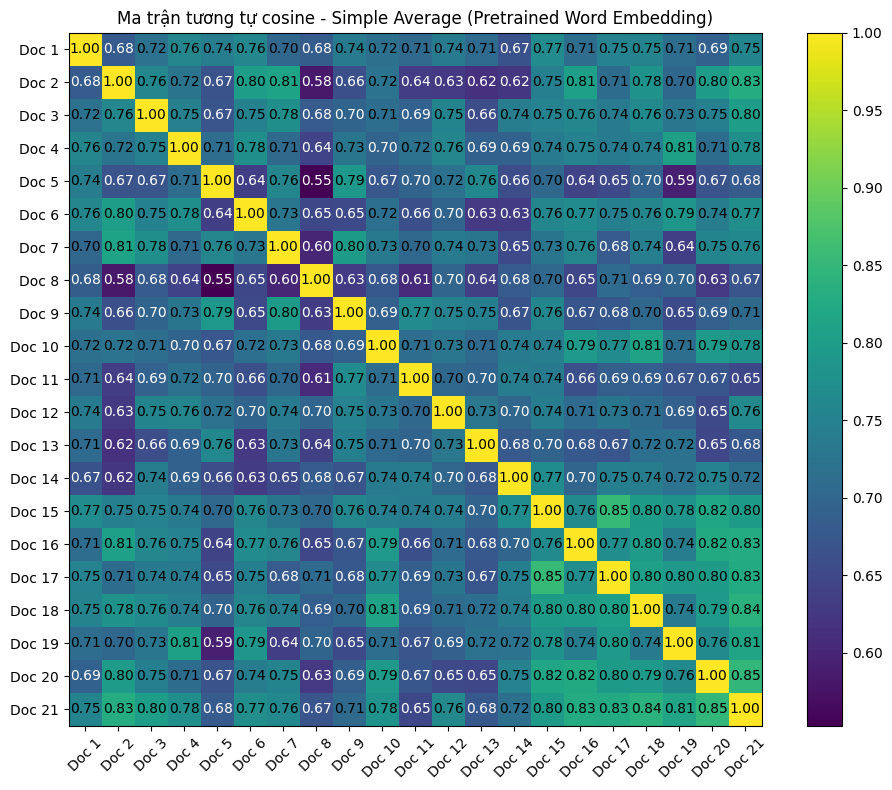

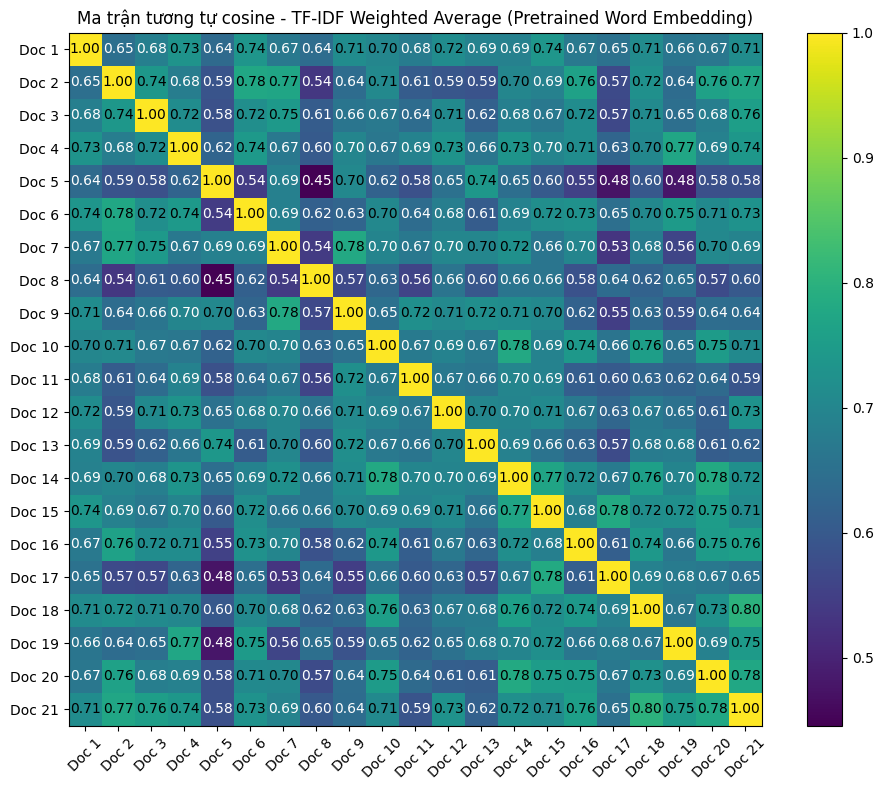

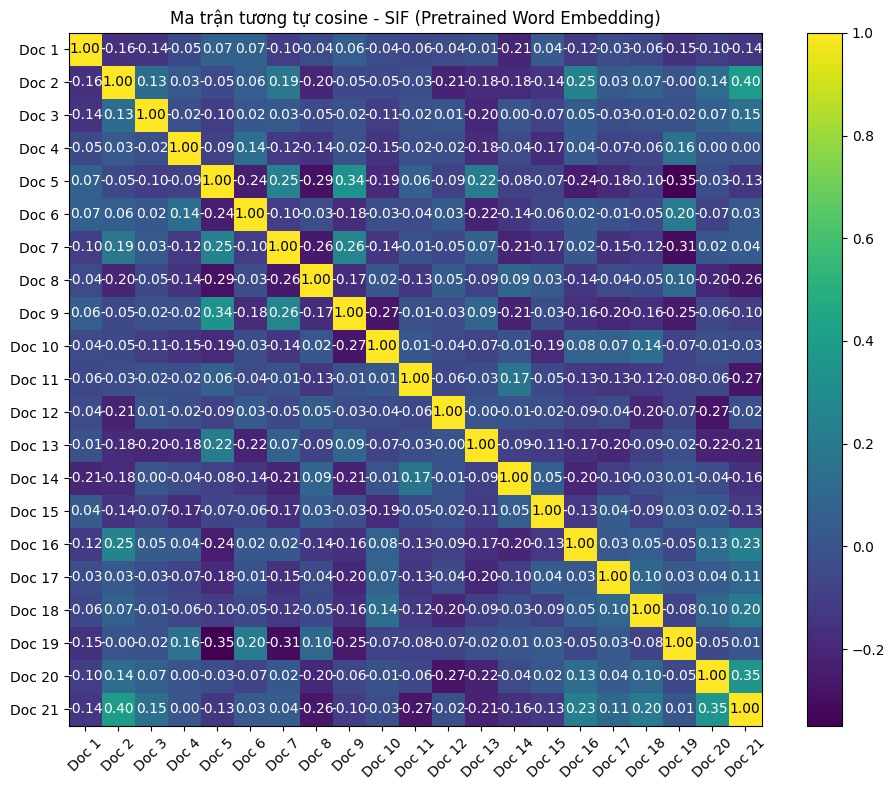


Phân tích tương tự theo chủ đề:
Tài liệu về chó: [0, 1, 2, 3, 4, 5, 6]
Tài liệu về mèo: [7, 8, 9, 10, 11, 12, 13]
Tài liệu về cả chó và mèo: [14, 15, 16, 17, 18, 19, 20]

Độ tương tự trung bình giữa các nhóm (phương pháp Simple Average):
Giữa các tài liệu về chó: 0.7329
Giữa các tài liệu về mèo: 0.6998
Giữa tài liệu về chó và mèo: 0.6885
Giữa tài liệu về chó và tài liệu về cả hai: 0.7369
Giữa tài liệu về mèo và tài liệu về cả hai: 0.7088


In [96]:
def plot_similarity_heatmap(similarity_matrix, method_name):
    """Vẽ heatmap cho ma trận tương tự"""
    plt.figure(figsize=(10, 8))
    plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    
    # Thêm nhãn cho các tài liệu
    labels_display = [f"Doc {i+1}" for i in range(len(similarity_matrix))]
    plt.xticks(range(len(labels_display)), labels_display, rotation=45)
    plt.yticks(range(len(labels_display)), labels_display)
    
    # Thêm giá trị tương tự lên heatmap
    for i in range(len(similarity_matrix)):
        for j in range(len(similarity_matrix)):
            text = plt.text(j, i, f"{similarity_matrix[i, j]:.2f}",
                           ha="center", va="center", color="w" if similarity_matrix[i, j] < 0.7 else "black")
    
    plt.title(f'Ma trận tương tự cosine - {method_name}')
    plt.tight_layout()
    plt.show()

# Tính ma trận tương tự cosine giữa các tài liệu
simple_similarity = cosine_similarity(simple_doc_vectors)
tfidf_similarity = cosine_similarity(tfidf_doc_vectors)
sif_similarity = cosine_similarity(sif_doc_vectors)

# Hiển thị ma trận tương tự
print("Trực quan hóa ma trận tương tự giữa các tài liệu:")
plot_similarity_heatmap(simple_similarity, 'Simple Average (Pretrained Word Embedding)')
plot_similarity_heatmap(tfidf_similarity, 'TF-IDF Weighted Average (Pretrained Word Embedding)')
plot_similarity_heatmap(sif_similarity, 'SIF (Pretrained Word Embedding)')

# Phân tích tương tự theo chủ đề
dog_indices = [i for i, label in enumerate(labels) if label == 0]
cat_indices = [i for i, label in enumerate(labels) if label == 1]
both_indices = [i for i, label in enumerate(labels) if label == 2]

print("\nPhân tích tương tự theo chủ đề:")
print(f"Tài liệu về chó: {dog_indices}")
print(f"Tài liệu về mèo: {cat_indices}")
print(f"Tài liệu về cả chó và mèo: {both_indices}")

# Tính độ tương tự trung bình trong và giữa các chủ đề
def calculate_group_similarities(similarity_matrix, indices1, indices2=None):
    if indices2 is None:
        # Tính tương tự trong cùng nhóm
        similarities = []
        for i in range(len(indices1)):
            for j in range(i+1, len(indices1)):
                similarities.append(similarity_matrix[indices1[i], indices1[j]])
        return np.mean(similarities) if similarities else 0
    else:
        # Tính tương tự giữa hai nhóm
        similarities = []
        for i in indices1:
            for j in indices2:
                similarities.append(similarity_matrix[i, j])
        return np.mean(similarities) if similarities else 0

# Tính và hiển thị độ tương tự giữa các nhóm tài liệu
print("\nĐộ tương tự trung bình giữa các nhóm (phương pháp Simple Average):")
if len(dog_indices) > 1:
    dog_dog_sim = calculate_group_similarities(simple_similarity, dog_indices)
    print(f"Giữa các tài liệu về chó: {dog_dog_sim:.4f}")

if len(cat_indices) > 1:
    cat_cat_sim = calculate_group_similarities(simple_similarity, cat_indices)
    print(f"Giữa các tài liệu về mèo: {cat_cat_sim:.4f}")

if dog_indices and cat_indices:
    dog_cat_sim = calculate_group_similarities(simple_similarity, dog_indices, cat_indices)
    print(f"Giữa tài liệu về chó và mèo: {dog_cat_sim:.4f}")

if dog_indices and both_indices:
    dog_both_sim = calculate_group_similarities(simple_similarity, dog_indices, both_indices)
    print(f"Giữa tài liệu về chó và tài liệu về cả hai: {dog_both_sim:.4f}")

if cat_indices and both_indices:
    cat_both_sim = calculate_group_similarities(simple_similarity, cat_indices, both_indices)
    print(f"Giữa tài liệu về mèo và tài liệu về cả hai: {cat_both_sim:.4f}")


Kết quả phân loại của Simple Average (Pretrained Word Embedding):
Độ chính xác phân loại: 0.8889
Kết quả dự đoán chi tiết:
Tài liệu: "Cả chó và mèo đều có thể được huấn luyện sử dụng k..." 
Nhãn thực: cả hai, Dự đoán: cả hai

Tài liệu: "Mèo Birman có bốn chân trắng như đi tất và được co..." 
Nhãn thực: mèo, Dự đoán: mèo

Tài liệu: "Mèo Scottish Fold có đặc điểm nổi bật là đôi tai c..." 
Nhãn thực: mèo, Dự đoán: mèo

Tài liệu: "Mèo Abyssinian có bộ lông ngắn với màu sắc đặc trư..." 
Nhãn thực: mèo, Dự đoán: mèo

Tài liệu: "Chó Beagle có đôi tai dài và thường được sử dụng t..." 
Nhãn thực: chó, Dự đoán: chó

Tài liệu: "Trong khi chó thường cần dắt đi dạo hàng ngày thì ..." 
Nhãn thực: cả hai, Dự đoán: cả hai

Tài liệu: "Chó Dalmatian nổi tiếng với những đốm đen trên nền..." 
Nhãn thực: chó, Dự đoán: chó

Tài liệu: "Chó Husky có đôi mắt màu xanh biển hoặc một mắt xa..." 
Nhãn thực: chó, Dự đoán: mèo

Tài liệu: "Cả chó và mèo đều có thể mắc các bệnh về đường tiê..." 
Nhãn thực: cả hai, Dự

C:\Users\NguyenKhang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\NguyenKhang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\NguyenKhang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was de

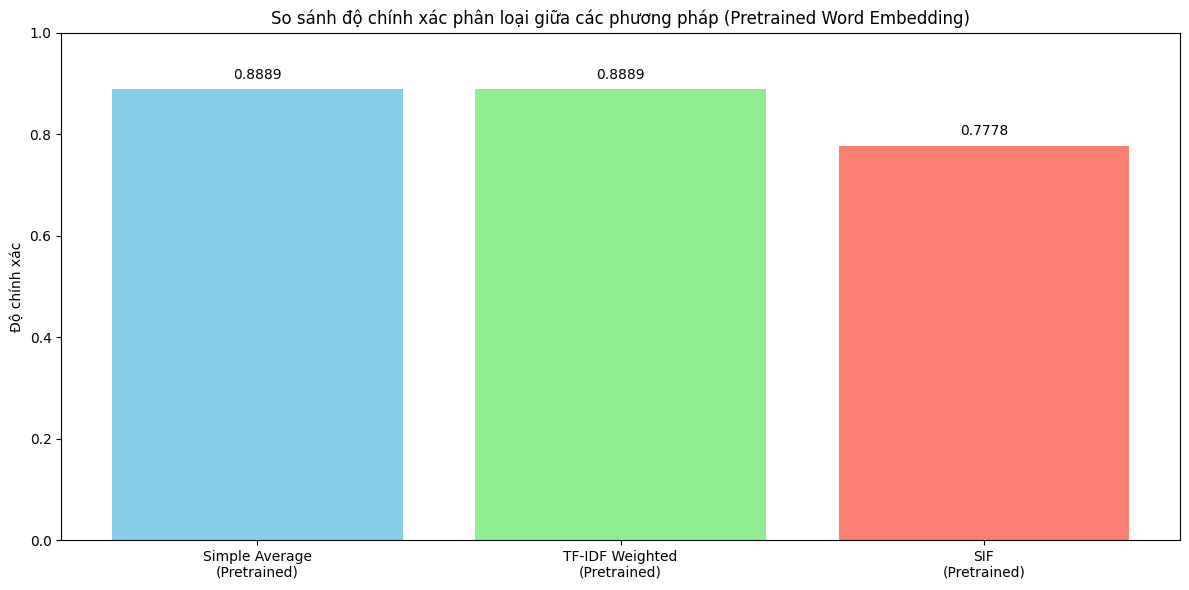

In [100]:
def evaluate_classification(vectors, labels, model_name, n_classes=3):
    """Đánh giá hiệu suất phân loại"""
    # Chuyển đổi nhãn nếu cần
    labels_array = np.array(labels)
    
    # Chia dữ liệu thành train và test
    X_train, X_test, y_train, y_test = train_test_split(
        vectors, labels_array, test_size=0.4, random_state=42, stratify=labels_array if len(set(labels_array)) > 1 else None
    )
    
    # Huấn luyện mô hình phân loại
    clf = LogisticRegression(max_iter=2000, multi_class='auto', solver='lbfgs')
    clf.fit(X_train, y_train)
    
    # Dự đoán và đánh giá
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nKết quả phân loại của {model_name}:")
    print(f"Độ chính xác phân loại: {accuracy:.4f}")
    
    # Hiển thị kết quả chi tiết nếu có đủ dữ liệu
    if len(X_test) > 1:
        print("Kết quả dự đoán chi tiết:")
        for i, (true, pred) in enumerate(zip(y_test, y_pred)):
            doc_idx = np.where(np.all(vectors == X_test[i], axis=1))[0][0]
            class_names = ["chó", "mèo", "cả hai"]
            print(f"Tài liệu: \"{documents[doc_idx][:50]}...\" ")
            print(f"Nhãn thực: {class_names[true]}, Dự đoán: {class_names[pred]}")
            print()
    
    return {
        "accuracy": accuracy,
        "model": clf
    }

# Đánh giá hiệu suất phân loại của các phương pháp
simple_result = evaluate_classification(simple_doc_vectors, labels, "Simple Average (Pretrained Word Embedding)")
tfidf_result = evaluate_classification(tfidf_doc_vectors, labels, "TF-IDF Weighted (Pretrained Word Embedding)")
sif_result = evaluate_classification(sif_doc_vectors, labels, "SIF (Pretrained Word Embedding)")

# So sánh độ chính xác
methods = ["Simple Average\n(Pretrained)", "TF-IDF Weighted\n(Pretrained)", "SIF\n(Pretrained)"]
accuracies = [simple_result["accuracy"], tfidf_result["accuracy"], sif_result["accuracy"]]

plt.figure(figsize=(12, 6))
plt.bar(methods, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1)
plt.ylabel('Độ chính xác')
plt.title('So sánh độ chính xác phân loại giữa các phương pháp (Pretrained Word Embedding)')

# Thêm giá trị lên đỉnh các cột
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

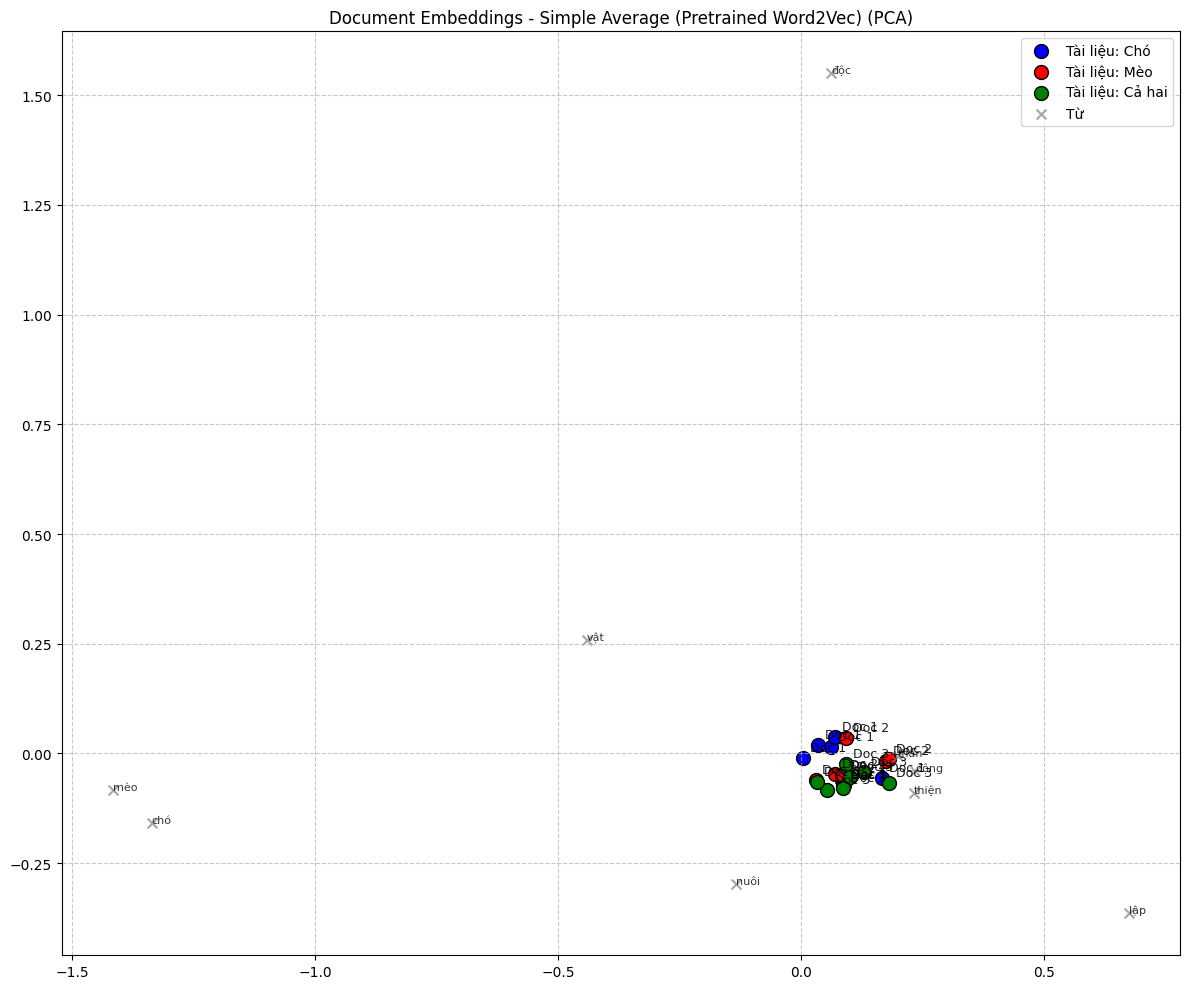

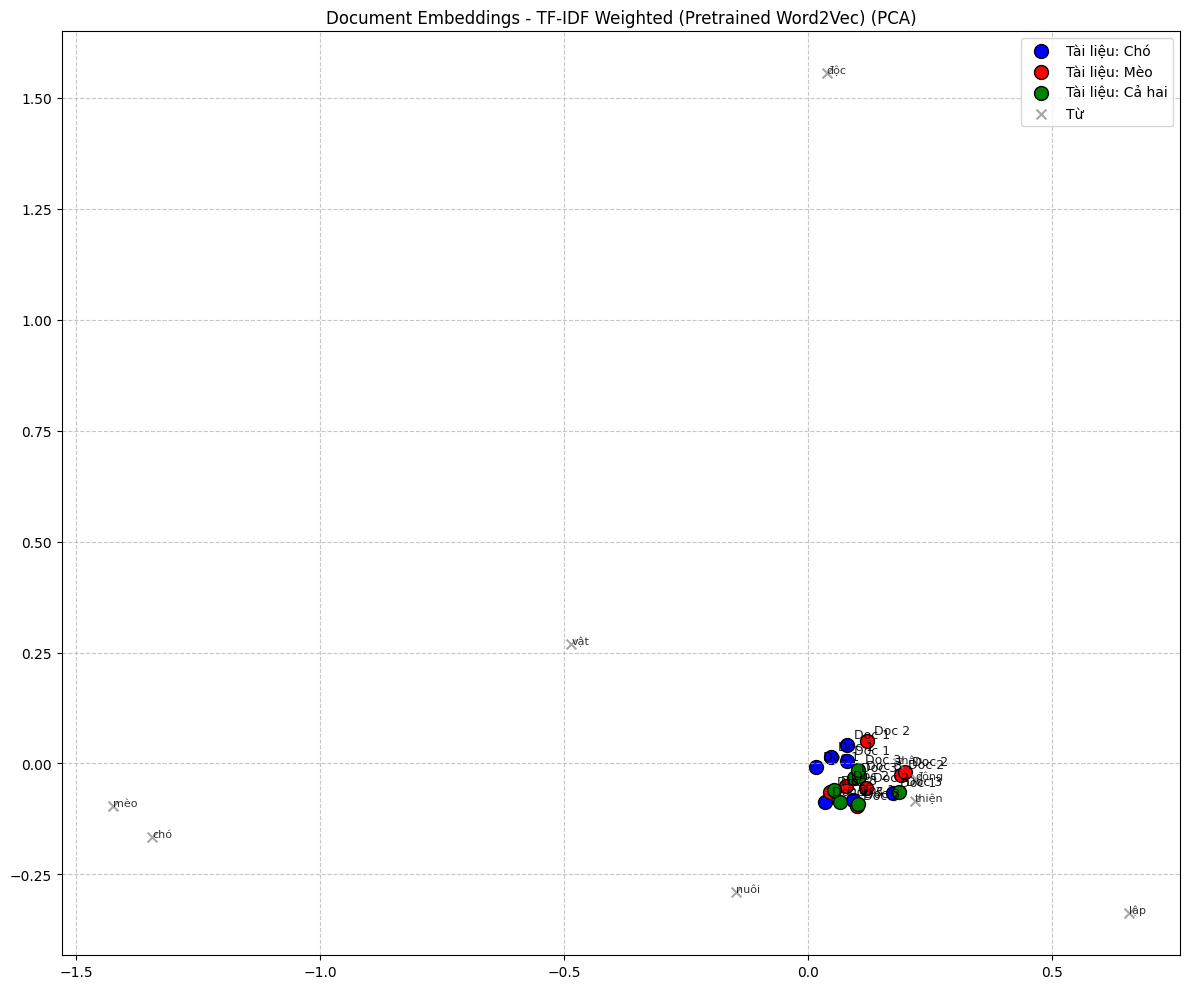

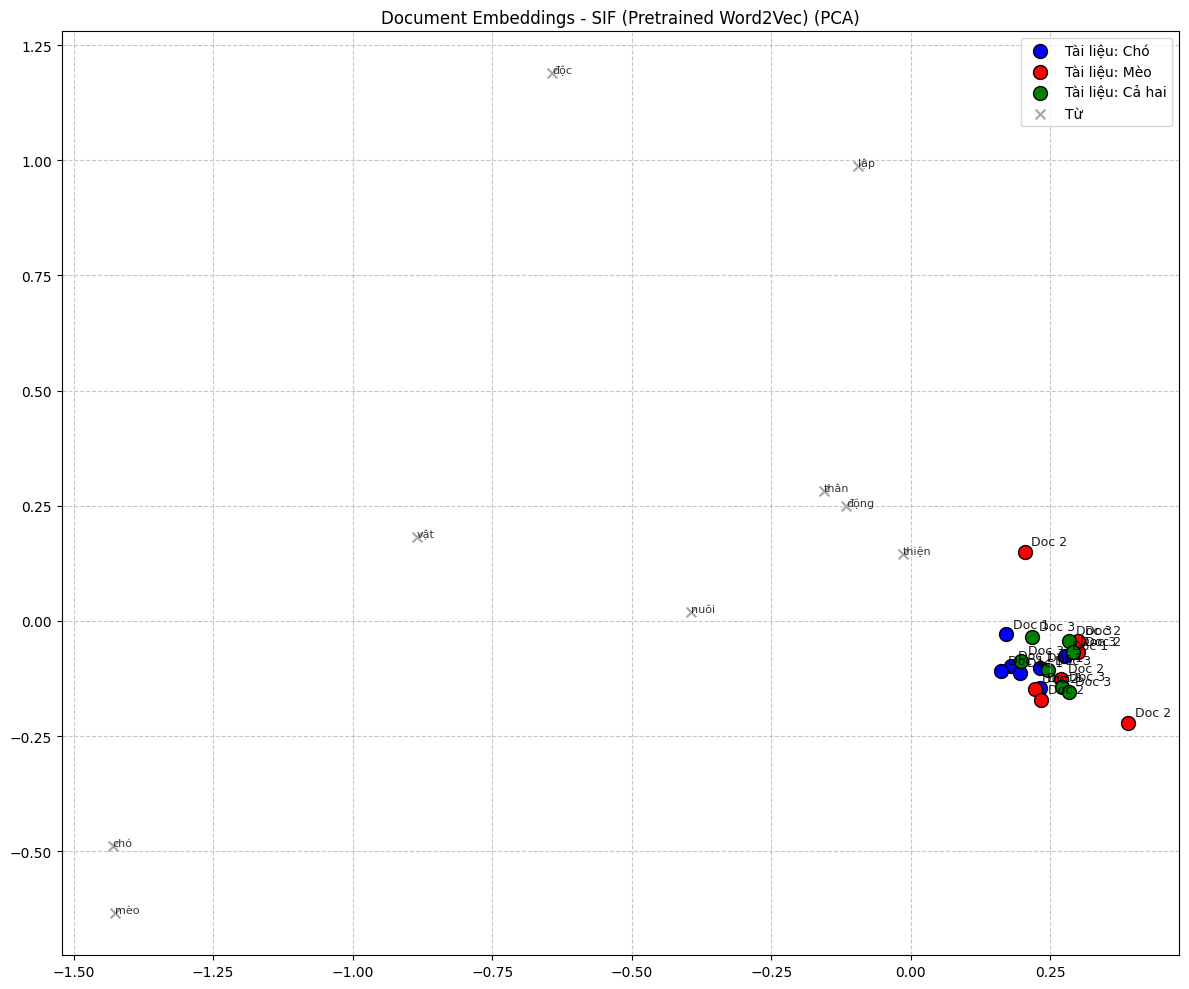

In [76]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_embeddings(document_vectors, labels, words=None, word_vectors=None, title="Document Embeddings"):
    """
    Trực quan hóa vector tài liệu và từ (tùy chọn) bằng PCA hoặc t-SNE
    """
    # Chuẩn bị dữ liệu
    all_vectors = document_vectors.copy()
    all_labels = ['doc-' + str(i) for i in labels]
    
    if words is not None and word_vectors is not None:
        all_vectors = np.vstack([all_vectors, word_vectors])
        all_labels.extend(['word-' + w for w in words])
    
    # Giảm chiều xuống 2D
    if len(all_vectors) > 50:  # Sử dụng t-SNE cho dữ liệu lớn
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(all_vectors)-1))
        vectors_2d = tsne.fit_transform(all_vectors)
        method = "t-SNE"
    else:  # Sử dụng PCA cho dữ liệu nhỏ
        pca = PCA(n_components=2)
        vectors_2d = pca.fit_transform(all_vectors)
        method = "PCA"
    
    # Vẽ biểu đồ
    plt.figure(figsize=(12, 10))
    
    # Phân loại các điểm theo nhãn
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    markers = ['o', 's', '^', 'D', 'v']
    
    # Vẽ các tài liệu
    doc_indices = [i for i, label in enumerate(all_labels) if 'doc-' in label]
    for label_value in set([int(all_labels[i].split('-')[1]) for i in doc_indices]):
        indices = [i for i in doc_indices if int(all_labels[i].split('-')[1]) == label_value]
        label_name = "Chó" if label_value == 0 else "Mèo" if label_value == 1 else "Cả hai"
        plt.scatter(
            vectors_2d[indices, 0], 
            vectors_2d[indices, 1], 
            color=colors[label_value % len(colors)], 
            marker=markers[0],
            label=f'Tài liệu: {label_name}',
            s=100,
            edgecolors='black'
        )
    
    # Vẽ các từ (nếu có)
    if words is not None:
        word_indices = [i for i, label in enumerate(all_labels) if 'word-' in label]
        plt.scatter(
            vectors_2d[word_indices, 0], 
            vectors_2d[word_indices, 1], 
            color='gray', 
            marker='x',
            label='Từ',
            s=50,
            alpha=0.7
        )
        
        # Thêm nhãn cho các từ
        for i in word_indices:
            plt.annotate(
                all_labels[i].replace('word-', ''),
                (vectors_2d[i, 0], vectors_2d[i, 1]),
                fontsize=8,
                alpha=0.8
            )
    
    # Thêm nhãn cho các tài liệu
    for i in doc_indices:
        doc_idx = int(all_labels[i].split('-')[1])
        doc_text = documents[doc_idx][:20] + "..." if len(documents[doc_idx]) > 20 else documents[doc_idx]
        plt.annotate(
            f"Doc {doc_idx+1}",
            (vectors_2d[i, 0], vectors_2d[i, 1]),
            fontsize=9,
            alpha=0.9,
            xytext=(5, 5),
            textcoords='offset points'
        )
    
    plt.title(f'{title} ({method})')
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Trích xuất một số từ quan trọng từ dữ liệu
important_words = ['chó', 'mèo', 'động', 'vật', 'nuôi', 'thân', 'thiện', 'độc', 'lập']
word_vectors = []
found_words = []

for word in important_words:
    if word in word2vec_model:
        word_vectors.append(word2vec_model[word])
        found_words.append(word)

word_vectors = np.array(word_vectors) if word_vectors else None

# Trực quan hóa vector tài liệu cho từng phương pháp
if word_vectors is not None:
    visualize_embeddings(
        simple_doc_vectors, 
        labels, 
        words=found_words, 
        word_vectors=word_vectors, 
        title="Document Embeddings - Simple Average (Pretrained Word2Vec)"
    )
    
    visualize_embeddings(
        tfidf_doc_vectors, 
        labels, 
        words=found_words, 
        word_vectors=word_vectors, 
        title="Document Embeddings - TF-IDF Weighted (Pretrained Word2Vec)"
    )
    
    visualize_embeddings(
        sif_doc_vectors, 
        labels, 
        words=found_words, 
        word_vectors=word_vectors, 
        title="Document Embeddings - SIF (Pretrained Word2Vec)"
    )
else:
    visualize_embeddings(simple_doc_vectors, labels, title="Document Embeddings - Simple Average (Pretrained Word2Vec)")
    visualize_embeddings(tfidf_doc_vectors, labels, title="Document Embeddings - TF-IDF Weighted (Pretrained Word2Vec)")
    visualize_embeddings(sif_doc_vectors, labels, title="Document Embeddings - SIF (Pretrained Word2Vec)")